# Exercise 4: Yule-Simon distribution

In this exercise we will look at the Yule-Simon and how to generate it using an Agent Based Model (ABM) implemented in Python using the `mesa` library.

The process to generate a Yule-Simon distribution describing firm sizes is as follows:

1. Start with a single firm of size 1.
2. At each time step, a new agent enters the market.
3. The agent may either decide to start a new firm with probability $p$ or join an existing firm with probability $1-p$ and then choose a firm to join with probability proportional to the size of the firm.



## Section 1: Read the "Introduction to Mesa" notebook

Before attempting this exercise, have a look at the companion Notebook "Introduction to Mesa" to get familiar with the library.

## Section 2: Implement the Yule-Simon model

Specifically implement the following three classes:

1. `Firm`: This class represent a firm. Its most important attribute is size.

2. `NewAgent`: This class represent a new agent entering the market.

3. `World`: This class should represent the world.

In [1]:
import mesa
import numpy as np

In [9]:
np.random.seed(41)

class Firm(mesa.Agent):
    """A firm that can hire employees."""

    def __init__(self, unique_id: int, model: "World", first_employee: "NewAgent"):
        super().__init__(unique_id, model)
        self.employees: list[mesa.Agent] = [first_employee]
        self.size = 1  # Start with a size of 1

    def hire(self, agent: "NewAgent"):
        """Hire a new employee.
        
        Tasks:
        1. Append the 'agent' to the 'self.employees' list.
        2. Increase 'self.size' by 1.
        3. Set the 'agent.employer' to 'self'.
        """
        # your code here
        self.employees.append(agent)
        self.size+=1
        agent.employer = self
    
    def fire(self, agent: "NewAgent"):
        """Remove the specified employee from list of employees"""
        self.employees.remove(agent)
        self.size-=1


class NewAgent(mesa.Agent):
    """An agent that can either found a new firm or join an existing one."""

    def __init__(self, unique_id: int, model: "World", max_size_mu=100, max_size_sigma=10):
        super().__init__(unique_id, model)
        self.employer: Firm | None = None  # Initially, the agent doesn't have an employer

        # 50% chance that an employee is indifferent about working in a large firm
        self.size_indifferent = np.random.uniform(0,1) < 0.5

        if self.size_indifferent:
            self.max_size_preference = np.random.normal(loc=10000, scale=max_size_sigma) # Lazy implementation / time constraint
        else:
            # If employee prefers to work in a smaller firm, we assign a normally distributed preference for the maximum size
            self.max_size_preference = np.random.normal(loc=max_size_mu, scale=max_size_sigma)

    def create_firm(self):
        """Found a new firm with the agent as the first employee.
        
        Use the 'create_firm' method from the 'World' model.
        """
        # your code here
        self.model.create_firm(self)


    def join_firm(self, firm: Firm):
        """Join an existing firm.
        
        Use the 'hire' method from the 'Firm' class.
        """
        # your code here
        firm.hire(self)

    def find_new_firm(self): 
        """Employee has quitted a firm because it was too large, and now must find a new firm in range of size preference
            Or become and entrepreneur after being too long in the corporate world. TODO: This probability could be increased to a larger one
        """
        firm_candidate = self.model.sample_firm()
        prob = np.random.uniform(low=0, high=1)
        while firm_candidate.size > self.max_size_preference and prob>self.model.start_up_prob:
            firm_candidate = self.model.sample_firm() # Resample to find an appropriate size of firm
            prob = np.random.uniform(low=0, high=1)
        if prob<= self.model.start_up_prob:
            self.create_firm()
        else:
            self.join_firm(firm_candidate)

    def step(self):
        """Define the agent's actions per step.
        
        Each step, the agent decides based on a probability (start_up_prob) whether to found a new firm 
        or join an existing one. Use the 'create_firm' method for founding a new firm and 'join_firm' 
        for joining an existing firm. Both methods are part of this class; 'sample_firm' is found in the 'World' class.
        """
        # your code here
        
        if self.model.employees_quit_model:
            self.find_new_firm() # Make sure to not join too large firm for own preference
        else:
            prob = np.random.uniform(low=0, high=1)
            if prob<=self.model.start_up_prob:
                self.create_firm()
            else:
                self.join_firm(self.model.sample_firm())

    def quit_firm(self):
        if self.employer:
            # Record data
            if self.employer in self.model.resigned_employees_data.keys():
                self.model.resigned_employees_data[self.employer].append(self)
            else:
                self.model.resigned_employees_data[self.employer] = [self]  
            
            # Remove employee
            self.employer.fire(self)
            self.employer = None

            if self.model.employees_quit_model:
                self.find_new_firm()
            else:
                prob = np.random.uniform(low=0, high=1)
                if prob<=self.model.start_up_prob:
                    self.create_firm()
                else:
                    self.join_firm(self.model.sample_firm())


## THIS CODE IS PROVIDED. YOU may want to adapt it for Section 3
class World(mesa.Model):
    """The model representing the world containing firms and agents."""

    def __init__(self, initial_agents=10, start_up_prob=0.1, collect_every=-1, employees_quit_model=False, max_size_mu=60, max_size_sigma=20):
        super().__init__()
        self.start_up_prob = start_up_prob  # Probability of starting a new firm
        self.firms = []  # List of firms
        self.collect_every = collect_every
        self.resigned_employees_data = {}
        self.schedule = mesa.time.BaseScheduler(self)
        self.employees_quit_model = employees_quit_model
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters={"Firm sizes": self.collect_firm_sizes}
        )

        # Initialize agents
        for i in range(initial_agents):
            agent = NewAgent(i, self, max_size_mu=max_size_mu, max_size_sigma=max_size_sigma)
            self.schedule.add(agent)  # Important: add agents to the schedule

        # Ensure at least one firm exists at the start
        self.create_firm(first_employee=self.schedule.agents[0])

    def create_firm(self, first_employee: NewAgent):
        """Create a new firm."""
        next_id = len(self.firms)
        firm = Firm(next_id, self, first_employee)
        self.firms.append(firm)

    def sample_firm(self):
        """Sample a firm proportionally to its size."""
        firm_sizes = [firm.size for firm in self.firms]
        total_size = sum(firm_sizes)
        probabilities = [size / total_size for size in firm_sizes]
        return self.random.choices(self.firms, weights=probabilities)[0]

    def full_employment(self):
        """Check if all agents are employed."""
        return all(agent.employer is not None for agent in self.schedule.agents)
    
    def collect_firm_sizes(self):
        """Collect the sizes of all firms."""
        return [firm.size for firm in self.firms]

    def step(self):
        """Advance the model by one step, activating only one agent."""
        if self.employees_quit_model:
            for firm in self.firms:
                for agent in firm.employees:
                    if agent.max_size_preference < firm.size:
                        agent.quit_firm()
                        if agent not in self.schedule.agents:
                            self.schedule.agents.add(agent)
        
        if len(self.schedule.agents) > 0:
            # Select a random agent to activate
            agent_to_activate = self.random.choice(self.schedule.agents)
            agent_to_activate.step()

            # Remove the agent after its step; it should not be activated again
            # if not self.employees_quit_model:
            self.schedule.remove(agent_to_activate)
            
            if self.collect_every == -1 and self.full_employment(): # collect only at the end
                self.datacollector.collect(self)
            elif self.collect_every >= 1 and self.schedule.steps % self.collect_every == 0:
                self.datacollector.collect(self)

            # End the simulation if all agents are employed
            if self.full_employment():
                self.running = False

### Run and plot the firm size distribution

In [3]:
import matplotlib.pyplot as plt

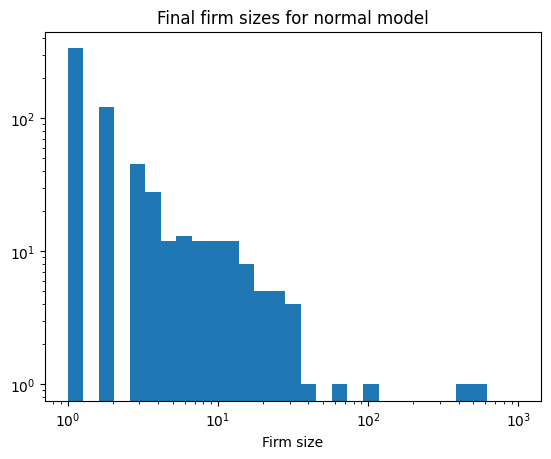

In [10]:
firm_model = World(3000, start_up_prob=0.2)
firm_model.run_model()

firm_sizes = firm_model.datacollector.get_model_vars_dataframe()["Firm sizes"].values
def plot_firm_sizes(firm_sizes, title: str):
    plt.hist(firm_sizes, bins=np.logspace(0, 3, 30))
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Firm size")
    plt.title(title)
    plt.show()

plot_firm_sizes(firm_sizes, "Final firm sizes for normal model")

In [11]:
def print_model_info(model: World):
    print("Largest firm size: \n", max([firm.size for firm in model.firms]))
    print("Smallest firm size: \n", min([firm.size for firm in model.firms]))
    print("Number of firms of size 1: \n", len([firm for firm in model.firms if firm.size == 1]))
    print("Number of firms: \n", len(model.firms))
    print("Sum of firm sizes \n", sum([firm.size for firm in model.firms]))
    if model.employees_quit_model:
        print("Amount of resignations from firm: \n", [len(firm_resignees) for firm_resignees in model.resigned_employees_data.values()])
        print("Final sizes of firms from where employees quit: \n",[firm.size for firm in model.resigned_employees_data.keys()])

In [12]:
print_model_info(firm_model)

Largest firm size: 
 518
Smallest firm size: 
 1
Number of firms of size 1: 
 334
Number of firms: 
 616
Sum of firm sizes 
 3001


## Section 3: Extend the model

Change some aspect of the model and see how the size distribution changes. For example, you could have Agents quitting if the the firm size is above a certain threshold. Or you could have the probability of starting a new firm depend on the size of the largest firm. Or you could introduce mergers between firms.

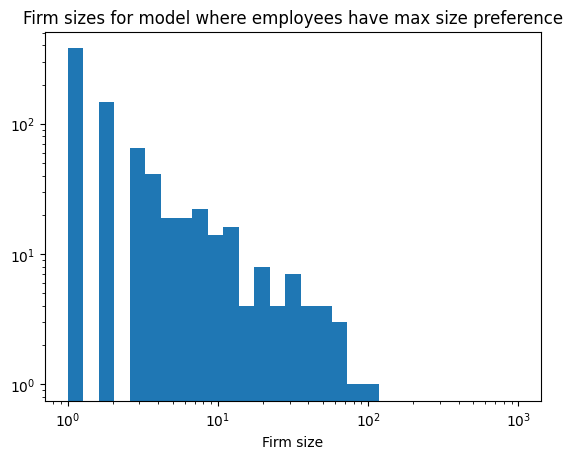

Largest firm size: 
 93
Smallest firm size: 
 1
Number of firms of size 1: 
 380
Number of firms: 
 758
Sum of firm sizes 
 3001
Amount of resignations from firm: 
 [58, 23, 18, 15, 11, 17, 16, 3, 6, 15, 3, 3, 3, 1, 3, 1, 5, 1, 1, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 3, 1]
Final sizes of firms from where employees quit: 
 [93, 75, 64, 51, 49, 60, 59, 34, 43, 57, 27, 32, 26, 7, 42, 24, 36, 6, 34, 51, 34, 8, 2, 6, 2, 26, 5, 12, 12, 34, 38, 3, 13, 2, 34, 21]


In [13]:
employees_quit_firm_model = World(initial_agents=3000, start_up_prob=0.2, employees_quit_model=True, max_size_mu=60, max_size_sigma=20)
employees_quit_firm_model.run_model()

employees_quit_firm_sizes = employees_quit_firm_model.datacollector.get_model_vars_dataframe()["Firm sizes"].values

plot_firm_sizes(employees_quit_firm_sizes, "Firm sizes for model where employees have max size preference")

print_model_info(employees_quit_firm_model)

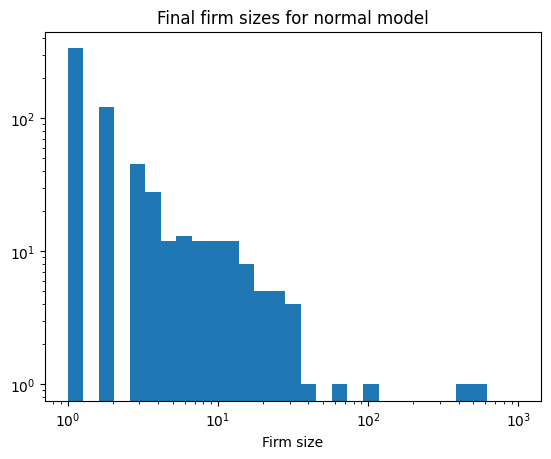

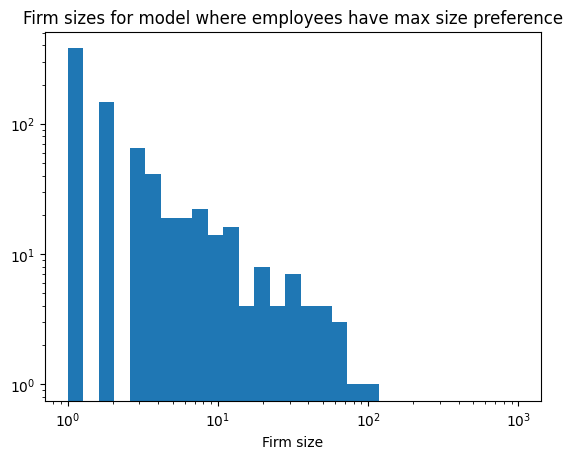

In [14]:
plot_firm_sizes(firm_sizes, "Final firm sizes for normal model")
plot_firm_sizes(employees_quit_firm_sizes, "Firm sizes for model where employees have max size preference")

## Extended Model Documentation

The idea for this model was to mimic employees preference for not working in a too large firm / corporation. For this we assign a 50/50 chance for each agent to either be indifferent of max size (except for the actual sampling of firms where larger firms are more likely), or to have a given preference for max size from a normal distribution. When a firm becomes too large for an agent's taste, he/she quits and finds another firm that is small enough or starts own firm according to the same start-up probability.

Challenges:
- There is a slight contradiction between the firm sampling where larger firms are preferred, and the max size preference
- Probability for starting up a new firm is probably a little bit biased when an agent has quit and is sampling a new firm in the correct size class. Looks like it is negligible based on the proportion of firms of size 1 